In [339]:
import random
import numpy as np
import pandas as pd
from statistics import stdev
from scipy.stats import truncnorm
from pandas.api.types import CategoricalDtype
random.seed(100)
#set base sets
ORs = ["1","2","3","4","5","6","7","8","9","10"]
Weekdays = ["Monday","Tuesday","Wednesday","Thursday","Firday"]
SurgeryTypes = ["CARD", "GASTRO", "GYN", "MED", "ORTH", "URO"]
WeekdayOrder = CategoricalDtype(Weekdays)
#generate patient list
def PatSimu(n):
    PL = []
    for i in range(0,n):
        if i < round(n*0.14):
            PL.append([i+1, 1, round(truncnorm.rvs(0,np.inf,99, 53))])
        elif i < round(n*(0.14 + 0.18)):
            PL.append([i+1, 2, round(truncnorm.rvs(0,np.inf,132, 76))])
        elif i < round(n*(0.14 + 0.18 + 0.28)):
            PL.append([i+1, 3, round(truncnorm.rvs(0,np.inf,78, 52))])
        elif i < round(n*(0.14 + 0.18 + 0.28 + 0.05)):
            PL.append([i+1, 4, round(truncnorm.rvs(0,np.inf,75, 72))])
        elif i < round(n*(0.14 + 0.18 + 0.28 + 0.05 + 0.17)):
            PL.append([i+1, 5, round(truncnorm.rvs(0,np.inf,142, 58))])
        else:
            PL.append([i+1, 6, round(truncnorm.rvs(0,np.inf,72, 38))])
    
    PatList = pd.DataFrame(data = PL, columns = ["PatNumber", "SurType","ExpDur"])
    return PatList



In [19]:
OS = [[2,2,2,0,0],
      [0,0,2,2,2],
      [1,0,1,0,1],
      [5,5,0,5,5],
      [0,5,4,0,0],
      [3,3,3,3,0],
      [0,3,3,3,3],
      [6,6,0,6,6],
      [1,0,6,0,1],
      [6,0,5,0,0],]
OS = pd.DataFrame(OS, columns = Weekdays, index = ORs)
OS

,Monday,Tuesday,Wednesday,Thursday,Firday
1,2,2,2,0,0
2,0,0,2,2,2
3,1,0,1,0,1
4,5,5,0,5,5
5,0,5,4,0,0
6,3,3,3,3,0
7,0,3,3,3,3
8,6,6,0,6,6
9,1,0,6,0,1
10,6,0,5,0,0


In [20]:
avg_em = [2,1,2,2,1,2]

In [21]:
avg_em

[2, 1, 2, 2, 1, 2]

In [22]:
mean_adv = [[99, 53], [132, 76], [78, 52], [75, 72], [142, 58], [72, 38]]

In [23]:
from scipy.stats import poisson

def em_simulate(specialty:int):
    if specialty == 0:
        #print([])
        return []
    else:
        n = poisson.rvs(avg_em[specialty - 1])
        mean = mean_adv[specialty - 1][0]
        adv = mean_adv[specialty - 1][1]
        sample = truncnorm.rvs(0,np.inf, mean, adv, size = n)
        sample = [round(x) for x in sample]
        #print(sample)
        return sample

In [24]:
def Greedy(lst: list, numb: int):
    RM = [0 for i in range(numb)]
    lst = sorted(lst)
    #print(RM)
    #print(lst)
    
    while len(lst) != 0:
        RM[RM.index(min(RM))] += lst[0]
        lst = lst[1:]
    #print(RM)
    return RM

In [25]:
24*60

1440

In [26]:
def SimuDay(Weekday:str):
    Day = list(OS[Weekday])
    #print(Day)
    EM = list(set(Day))
    EM = EM[1:]
    #print(EM)
    result = [0 for i in range(10)]
    #print(result)
    for x in EM:
        Today = em_simulate(x)
        #print(Today)
        n = Day.count(x)
        Spec = Greedy(Today, n)
        #print(Spec)
        k = 0
        for i in range(10):
            if Day[i] == x:
                result[i] = Spec[k]
                k += 1
                #print(result)
    for o in O:
        if result[o] > 24*60:
            result[o] = 24*60
    return result

In [27]:
def SimuWeek(n:int):
    res = []
    for i in range(n):
        out = []
        for x in Weekdays:
            out.append(SimuDay(x))
        final = pd.DataFrame(out, columns = ORs, index = Weekdays)
        res.append(final)
    return res

In [28]:
def GSL(t):
    GSL = []
    for i in range(samples):
        count = 0
        for o in O:
            for w in W:
                if t[o,w,i].x == 0:
                    count += 1
        GSL.append(count)
    return GSL


In [29]:
import gurobipy as gp
from gurobipy import GRB
import time
#parameters

O=range(10)
S=range(6)
W=range(5)
samples = 1000
random.seed(100)
simulation = SimuWeek(samples)

In [30]:
simulation[0]

,1,2,3,4,5,6,7,8,9,10
Monday,0,0,228,196,0,544,0,135,275,0
Tuesday,331,0,0,304,0,138,0,97,0,0
Wednesday,195,0,575,0,108,95,128,0,86,158
Thursday,0,528,0,226,0,107,0,226,0,0
Firday,0,0,290,226,0,0,118,213,109,0


In [506]:
n = 100
P=range(n)
PatList = PatSimu(n)

In [562]:
#set costs
cp = [36,38,34,32,40,30]
co = 1.5*35
base = [99*36,132*38,78*34,75*32,142*40,72*30]
cd = [2*x for x in base]
cc = [4*x for x in base]

In [563]:
#model
m = gp.Model("surgery")

m.ModelSense = 1

x = m.addVars(n, 10, 5, vtype = GRB.BINARY, name='x')
t = m.addVars(10, 5, samples, ub = 16*60, vtype=GRB.INTEGER, name='t')
y = m.addVars(n, vtype=GRB.BINARY, name='y')
z = m.addVars(n, 10, 5, samples, vtype = GRB.BINARY, name = "z")
eps = m.addVars(10, 5, vtype = GRB.INTEGER, name = "eps")

Cost = m.addVars(samples, obj = 1/samples, name = "COST")

#Set Constraints
m.addConstrs((Cost[i] == gp.quicksum(PatList.ExpDur[p]*cp[PatList.SurType[p] - 1]*(x[p,o,w] - z[p,o,w,i]) for o in O for w in W for p in P)
        + gp.quicksum(co * t[o,w,i] for o in O for w in W)
        + gp.quicksum(y[p]* cd[PatList.SurType[p] - 1] for p in P)
        + gp.quicksum(z[p,o,w,i]* cc[PatList.SurType[p] - 1] for p in P for o in O for w in W) for i in range(samples)), name = "COST")

m.addConstrs(gp.quicksum(x[p,o,w] for o in O for w in W) + y[p]== 1 for p in P)

m.addConstrs(x[p,o,w] <= (6 - abs(PatList.SurType[p] - OS.iloc[o][w]))/6  for w in W for o in O for p in P)

m.addConstrs(x[p,o,w] >= z[p,o,w,i] for i in range(samples) for p in P for o in O for w in W)

m.addConstrs(gp.quicksum(x[p,o,w]*PatList.ExpDur[p] for p in P) + eps[o,w] == 8*60 for o in O for w in W)

m.addConstrs(gp.quicksum(x[p,o,w]*PatList.ExpDur[p] for p in P) + simulation[i].iloc[w,o] 
            - gp.quicksum(z[p,o,w,i]*PatList.ExpDur[p] for p in P) 
            <= 8*60 + t[o,w,i] for o in O for w in W for i in range(samples)) 


m.update()
m.setParam('MIPGap', 0.02)
m.setParam('Timelimit', 3600)

m.optimize()

Set parameter MIPGap to value 0.02
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5056150 rows, 5056150 columns and 30216150 nonzeros
Model fingerprint: 0x95bfb9b9
Variable types: 1000 continuous, 5055150 integer (5005100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e-03, 1e-03]
  Bounds range     [1e+00, 1e+03]
  RHS range        [2e-01, 9e+02]
Presolve removed 1617 rows and 1050 columns (presolve time = 7s) ...
Presolve removed 6000 rows and 4388533 columns (presolve time = 11s) ...
Presolve removed 4407023 rows and 4406533 columns (presolve time = 15s) ...
Presolve removed 4407023 rows and 4406533 columns (presolve time = 20s) ...
Presolve removed 4407023 rows and 4406533 columns (presolve time = 28s) ...
Presolve removed 4407023 rows and 4406533 columns (presolve time = 30s) ...
Presolve remove

In [564]:

def MSS(x, y):
    MSS = []
    for p in P:
        if y[p].x == 1:
            MSS.append([p+1, "Postponed", "Postponed"])
        else:
            for o in O:
                for w in W:
                    if x[p,o,w].x == 1:
                        MSS.append([p+1, ORs[o], Weekdays[w]])
        
                
    MSS = pd.DataFrame(MSS, columns = ["PatNumber", "ORNumber", "Weekday"])
    WeekdayOrder = CategoricalDtype(Weekdays)
    MSS["Weekday"] = MSS["Weekday"].astype(WeekdayOrder)

    MSS = pd.merge(MSS,PatList, on = "PatNumber").set_index("PatNumber")
    return MSS

MSS1 = MSS(x, y)
print("first 10 scheduled patients:")
print()
print(MSS1.head(10))
print()
print("postponed patients:")
print()
print(MSS1[MSS1.ORNumber == "Postponed"])

first 10 scheduled patients:

            ORNumber Weekday  SurType  ExpDur
PatNumber                                    
1                  3  Monday        1     130
2                  9  Monday        1     131
3          Postponed     NaN        1     152
4          Postponed     NaN        1     166
5          Postponed     NaN        1     165
6                  3  Firday        1     115
7                  9  Monday        1     150
8          Postponed     NaN        1     187
9                  3  Firday        1     108
10                 9  Firday        1     130

postponed patients:

            ORNumber Weekday  SurType  ExpDur
PatNumber                                    
3          Postponed     NaN        1     152
4          Postponed     NaN        1     166
5          Postponed     NaN        1     165
8          Postponed     NaN        1     187
11         Postponed     NaN        1     197
13         Postponed     NaN        1     182
16         Postponed     NaN

In [565]:
#for v in m.getVars():
#    if v.x > 1e-6:
#       print(v.varName, v.x)

In [566]:
n_plan = sum(x[p,o,w].x for p in P for o in O for w in W)
plan_rate = n_plan/n
print("%.2f"%(plan_rate*100))
    
cancel_rate = [sum(z[p,o,w,i].x for p in P for o in O for w in W)/n_plan for i in range(samples)]

cost = [Cost[x].x for x in range(samples)]

59.00


In [567]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
from matplotlib.ticker import PercentFormatter
n_bins = 150
def doubleHist(data, xlabel=None):
    plt.figure(figsize=(14.5,6),dpi=600)
    gs  = gridspec.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.25)
    ax  = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])
    ax.grid(True)
    ax.set_title(xlabel)
    ax.set_ylabel('Likelihood of occurrence',color='blue')
    ax2 = ax.twinx()
    ax2.set_ylabel('Cumulative probability',color='red')
    # plot the density and cumulative histogram
    n, bins, patches = ax.hist(data, n_bins, density=True, alpha=0.65, cumulative=False, label='Density', color='blue')
    n, bins, patches = ax2.hist(data, n_bins, density=True, histtype='step', cumulative=True, label='CDF', color='red')
    ax3.boxplot(data,whis=[5,95])
    # tidy up the figure
    plt.show()

In [568]:
def Result(x, z, Cost, t):
    n_plan = sum(x[p,o,w].x for p in P for o in O for w in W)
    plan_rate = n_plan/n
    print("The plan rate is %.2f"%(plan_rate*100))
    cancel_rate = [sum(z[p,o,w,i].x for p in P for o in O for w in W)/n_plan for i in range(samples)]
    cost = [Cost[x].x for x in range(samples)]
    print("Avg cost", np.mean(cost))
    print("Avg c-rate %.2f"%(np.mean(cancel_rate)*100))
    print("Avg GSL", np.mean(GSL(t)))
    print("SD cost", stdev(cost))
    print("SD c-rate %.2f"%(stdev(cancel_rate*100)))
    print("SD GSL", stdev(GSL(t)))
    doubleHist(cost, xlabel = "Cost")
    doubleHist(cancel_rate, xlabel = "Cancel Rate")
    doubleHist(GSL(t), xlabel = "GSL")

In [569]:
def Time_Schedule(eps):
    schedule = []
    for o in O:
        for w in W:
            if OS.iloc[o][w] != 0:
                schedule.append([Weekdays[w], ORs[o], "Planning Time", 8*60 - eps[o,w].x])
                schedule.append([Weekdays[w], ORs[o], "Buffer Time", eps[o,w].x])
            else:
                schedule.append([Weekdays[w], ORs[o],'Planning Time', 'not open'])
                schedule.append([Weekdays[w], ORs[o],'Buffer Time', 'not open'])

    PLAN = pd.DataFrame(schedule, columns = ["Weekday", "OR", "Time", "Number"])
    WeekdayOrder = CategoricalDtype(Weekdays)
    PLAN["Weekday"] = PLAN["Weekday"].astype(WeekdayOrder)
    OROrder = CategoricalDtype(ORs)
    PLAN["OR"] = PLAN["OR"].astype(OROrder)
    SCH = pd.pivot(PLAN, values = "Number", index = ["OR"], columns = ["Weekday", "Time"])
    return SCH

In [570]:
Time_Schedule(eps)

Weekday        Monday                   Tuesday                 Wednesday   
Time    Planning Time Buffer Time Planning Time Buffer Time Planning Time   
OR                                                                          
1               284.0       196.0         334.0       146.0         287.0  \
2            not open    not open      not open    not open         348.0   
3               233.0       247.0      not open    not open           0.0   
4               332.0       148.0         305.0       175.0      not open   
5            not open    not open         321.0       159.0           0.0   
6                95.0       385.0         225.0       255.0         185.0   
7            not open    not open         303.0       177.0         294.0   
8               351.0       129.0         265.0       215.0      not open   
9               281.0       199.0      not open    not open         198.0   
10              362.0       118.0      not open    not open         171.0   

Weekday                  Thursday                    Firday              
Time    Buffer Time Planning Time Buffer Time Planning Time Buffer Time  
OR                                                                       
1             193.0      not open    not open      not open    not open  
2             132.0         182.0       298.0         148.0       332.0  
3             480.0      not open    not open         223.0       257.0  
4          not open         352.0       128.0         185.0       295.0  
5             480.0      not open    not open      not open    not open  
6             295.0         184.0       296.0      not open    not open  
7             186.0         307.0       173.0           0.0       480.0  
8          not open          88.0       392.0          90.0       390.0  
9             282.0      not open    not open         267.0       213.0  
10            309.0      not open    not open      not open    not open

The plan rate is 59.00
Avg cost 611793.215
Avg c-rate 0.01
Avg GSL 41.989
SD cost 23373.68642141632
SD c-rate 0.00
SD GSL 2.4663661451540326


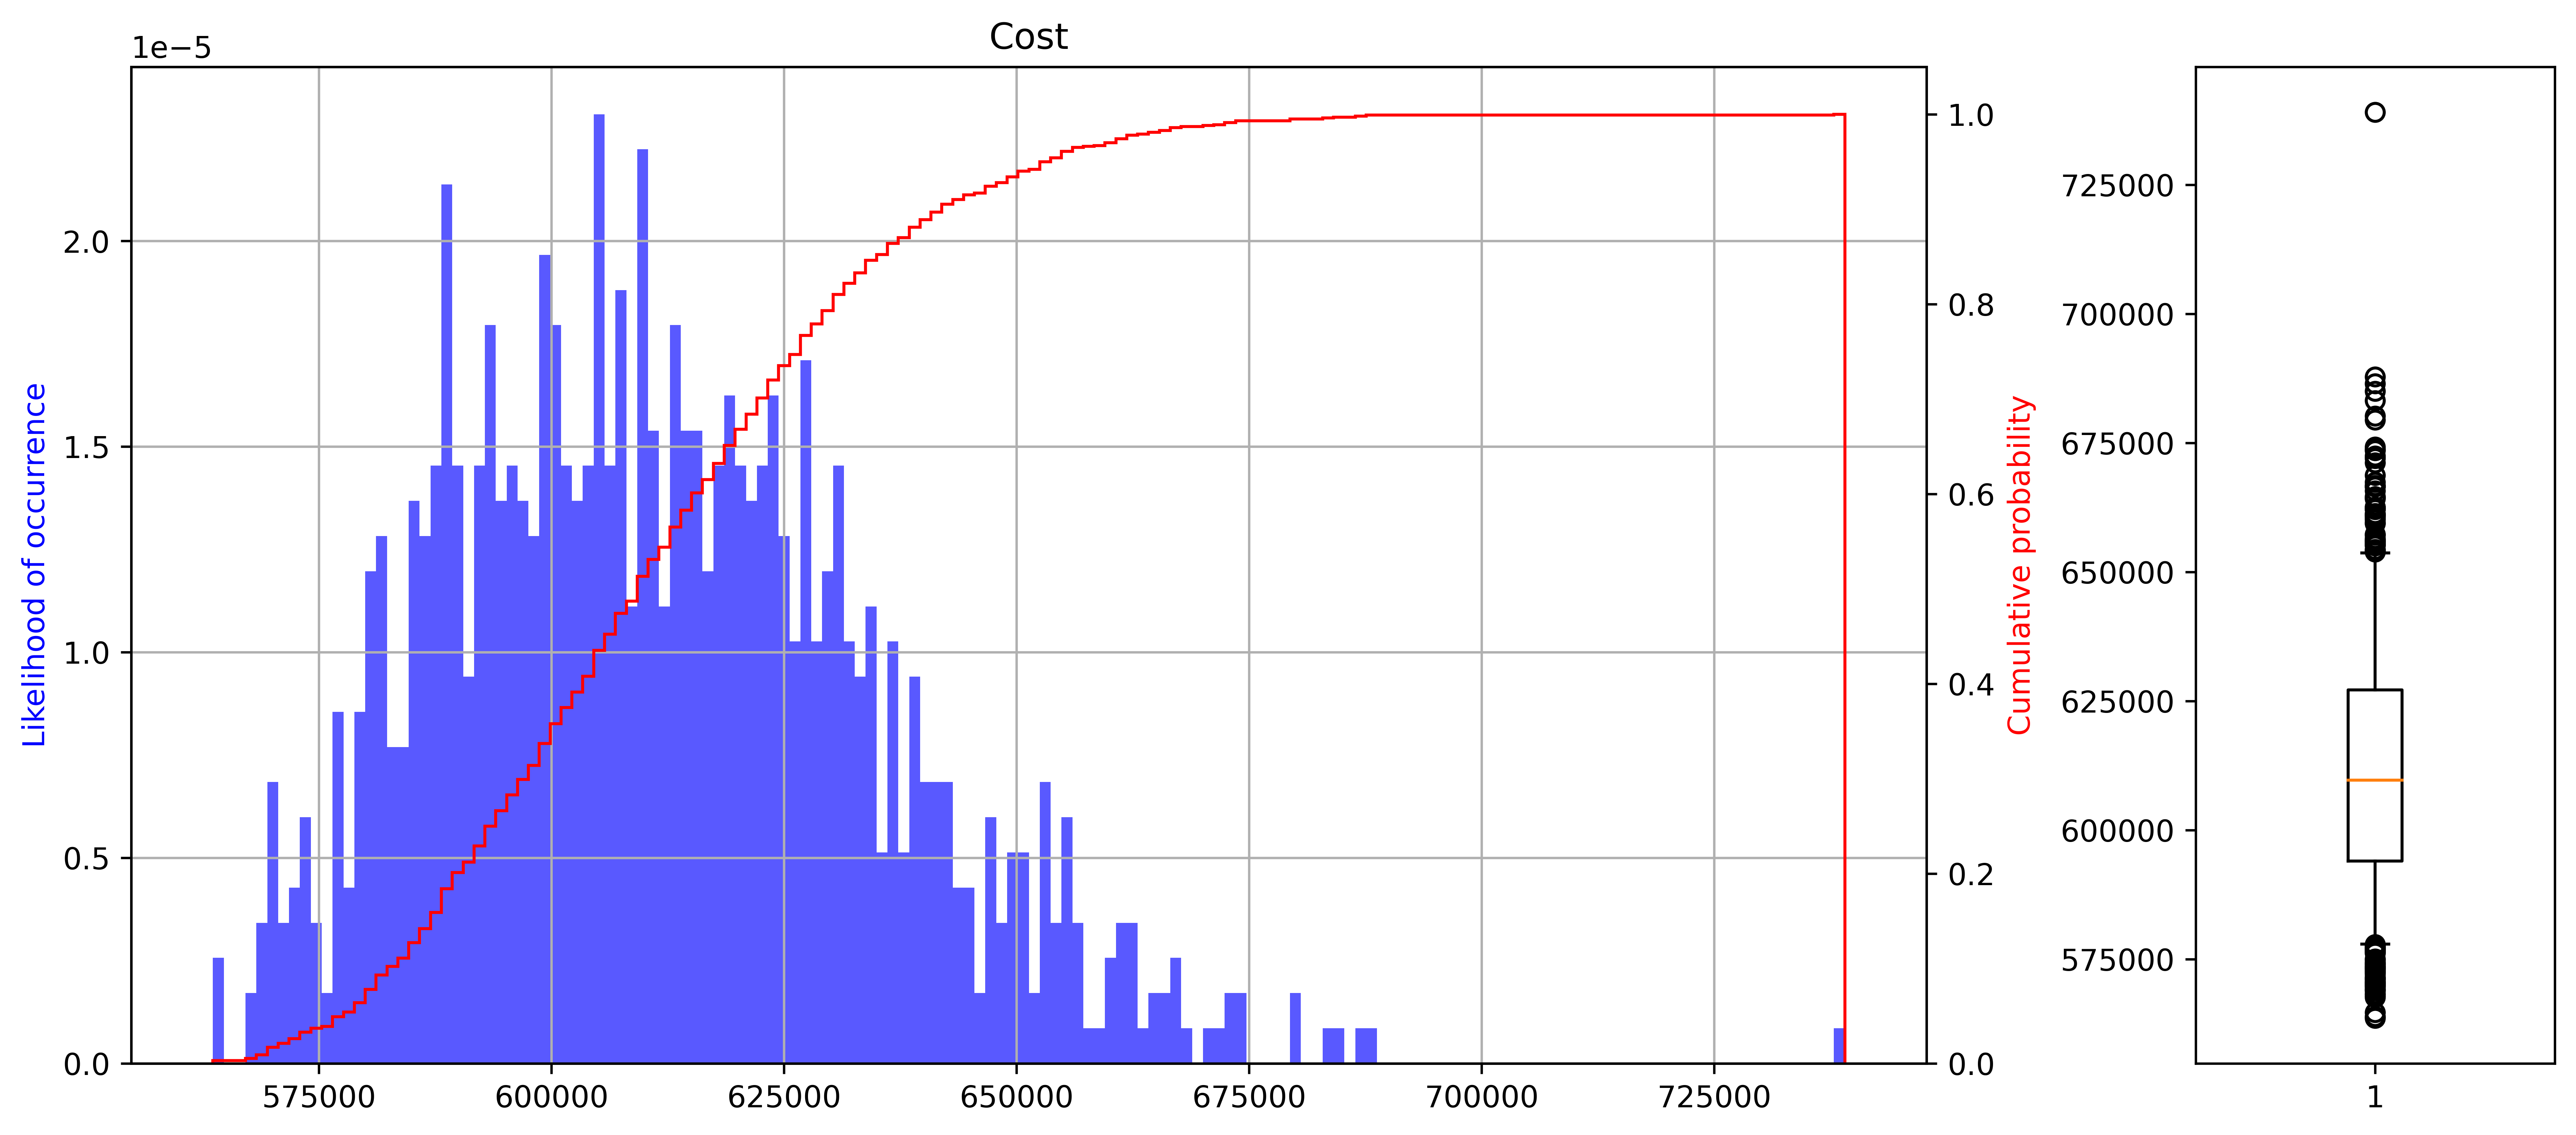

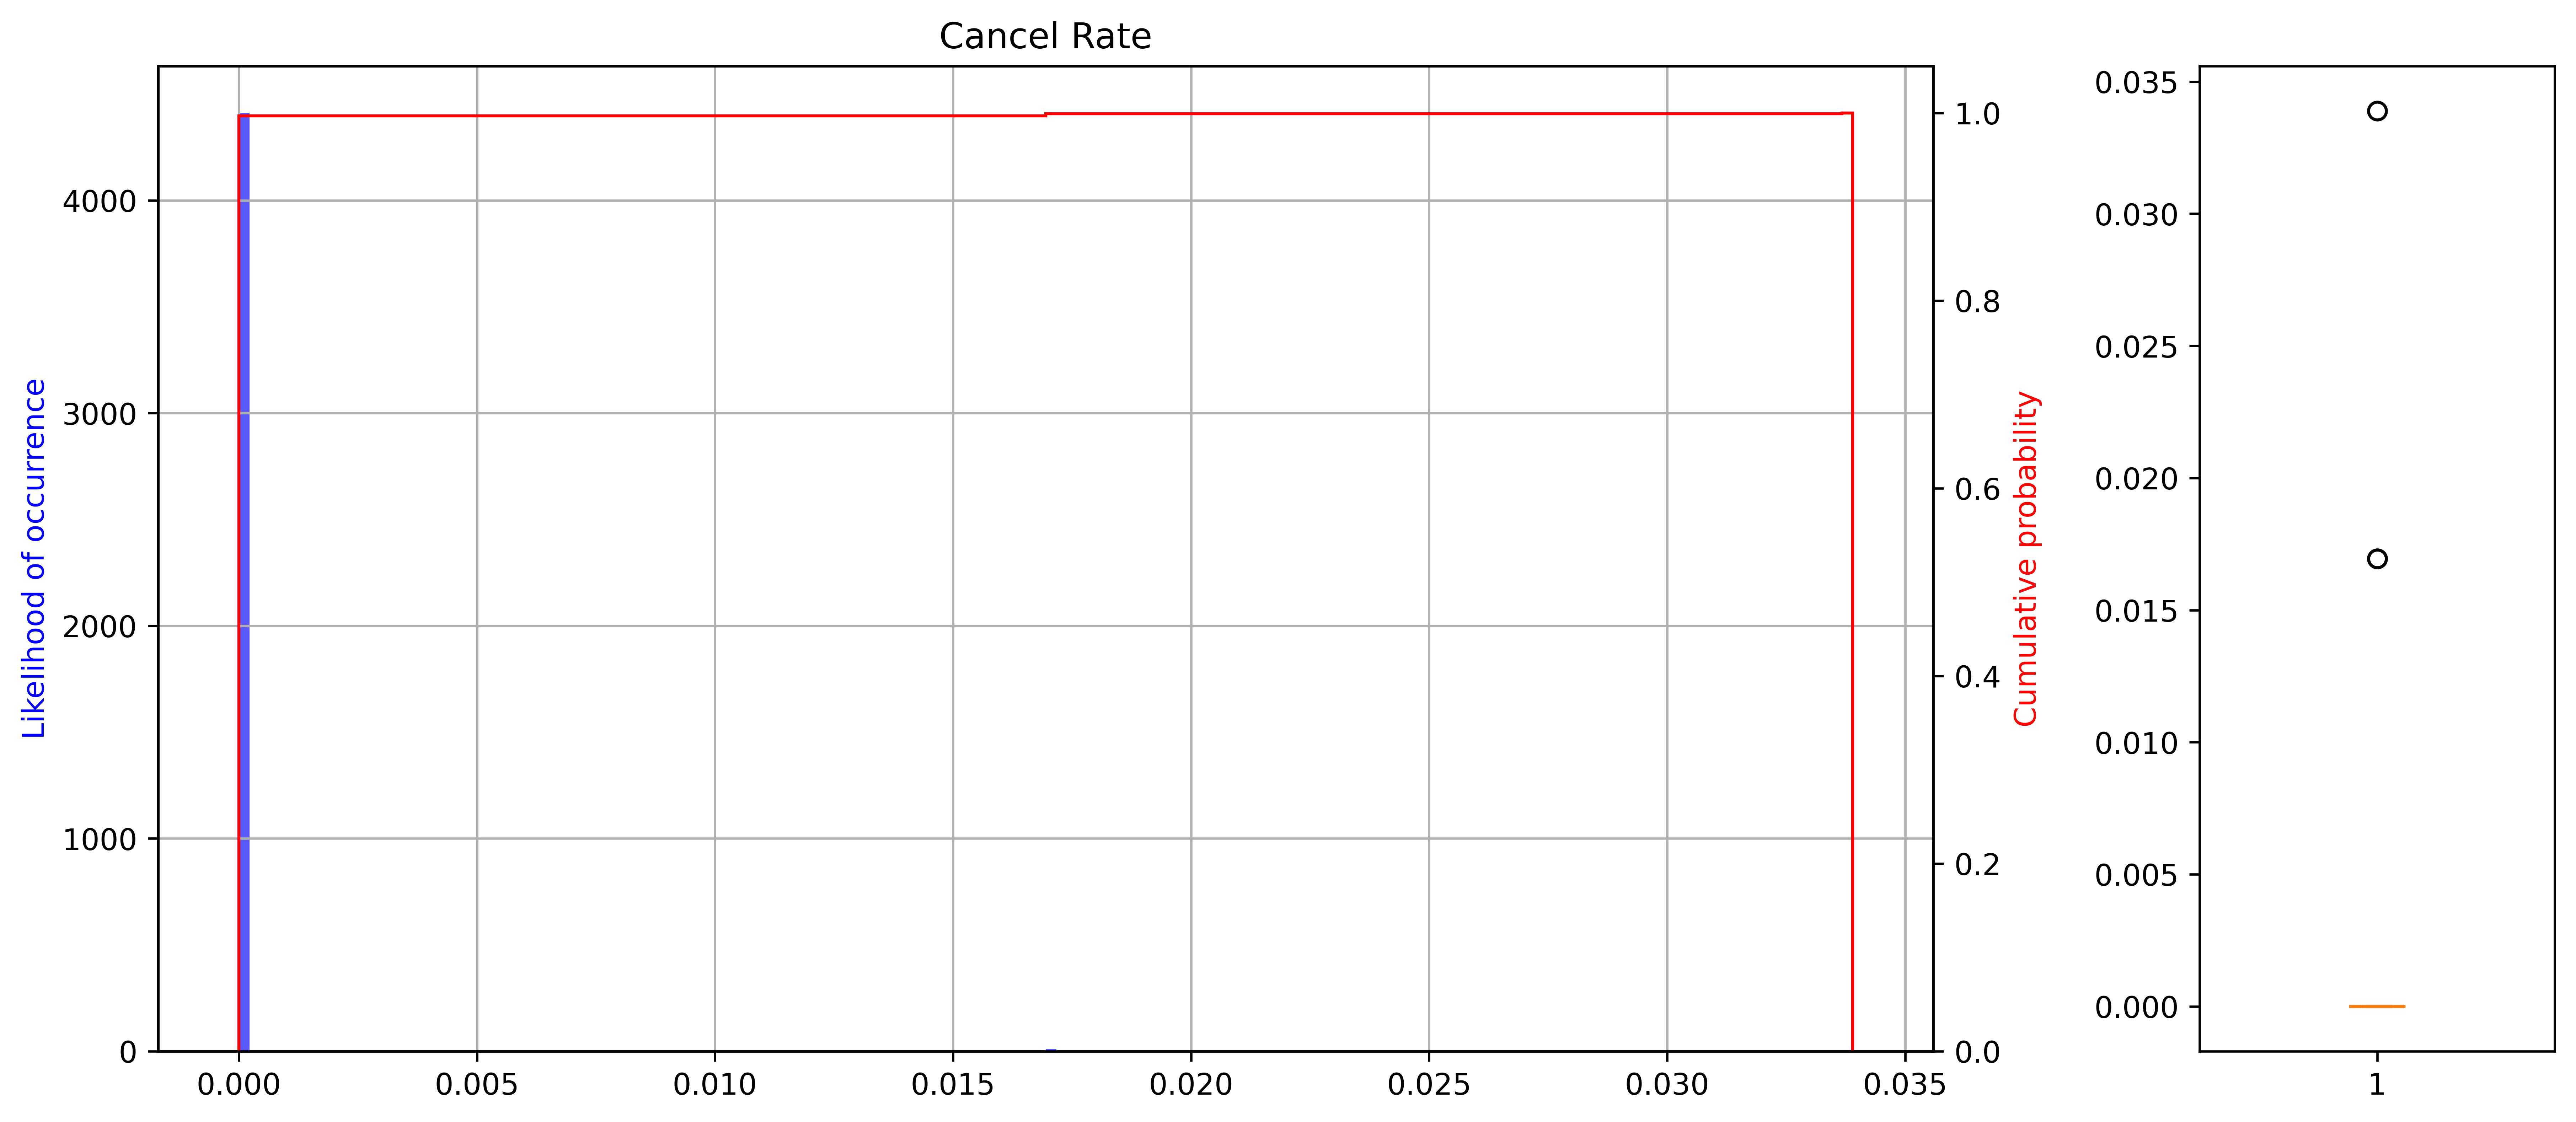

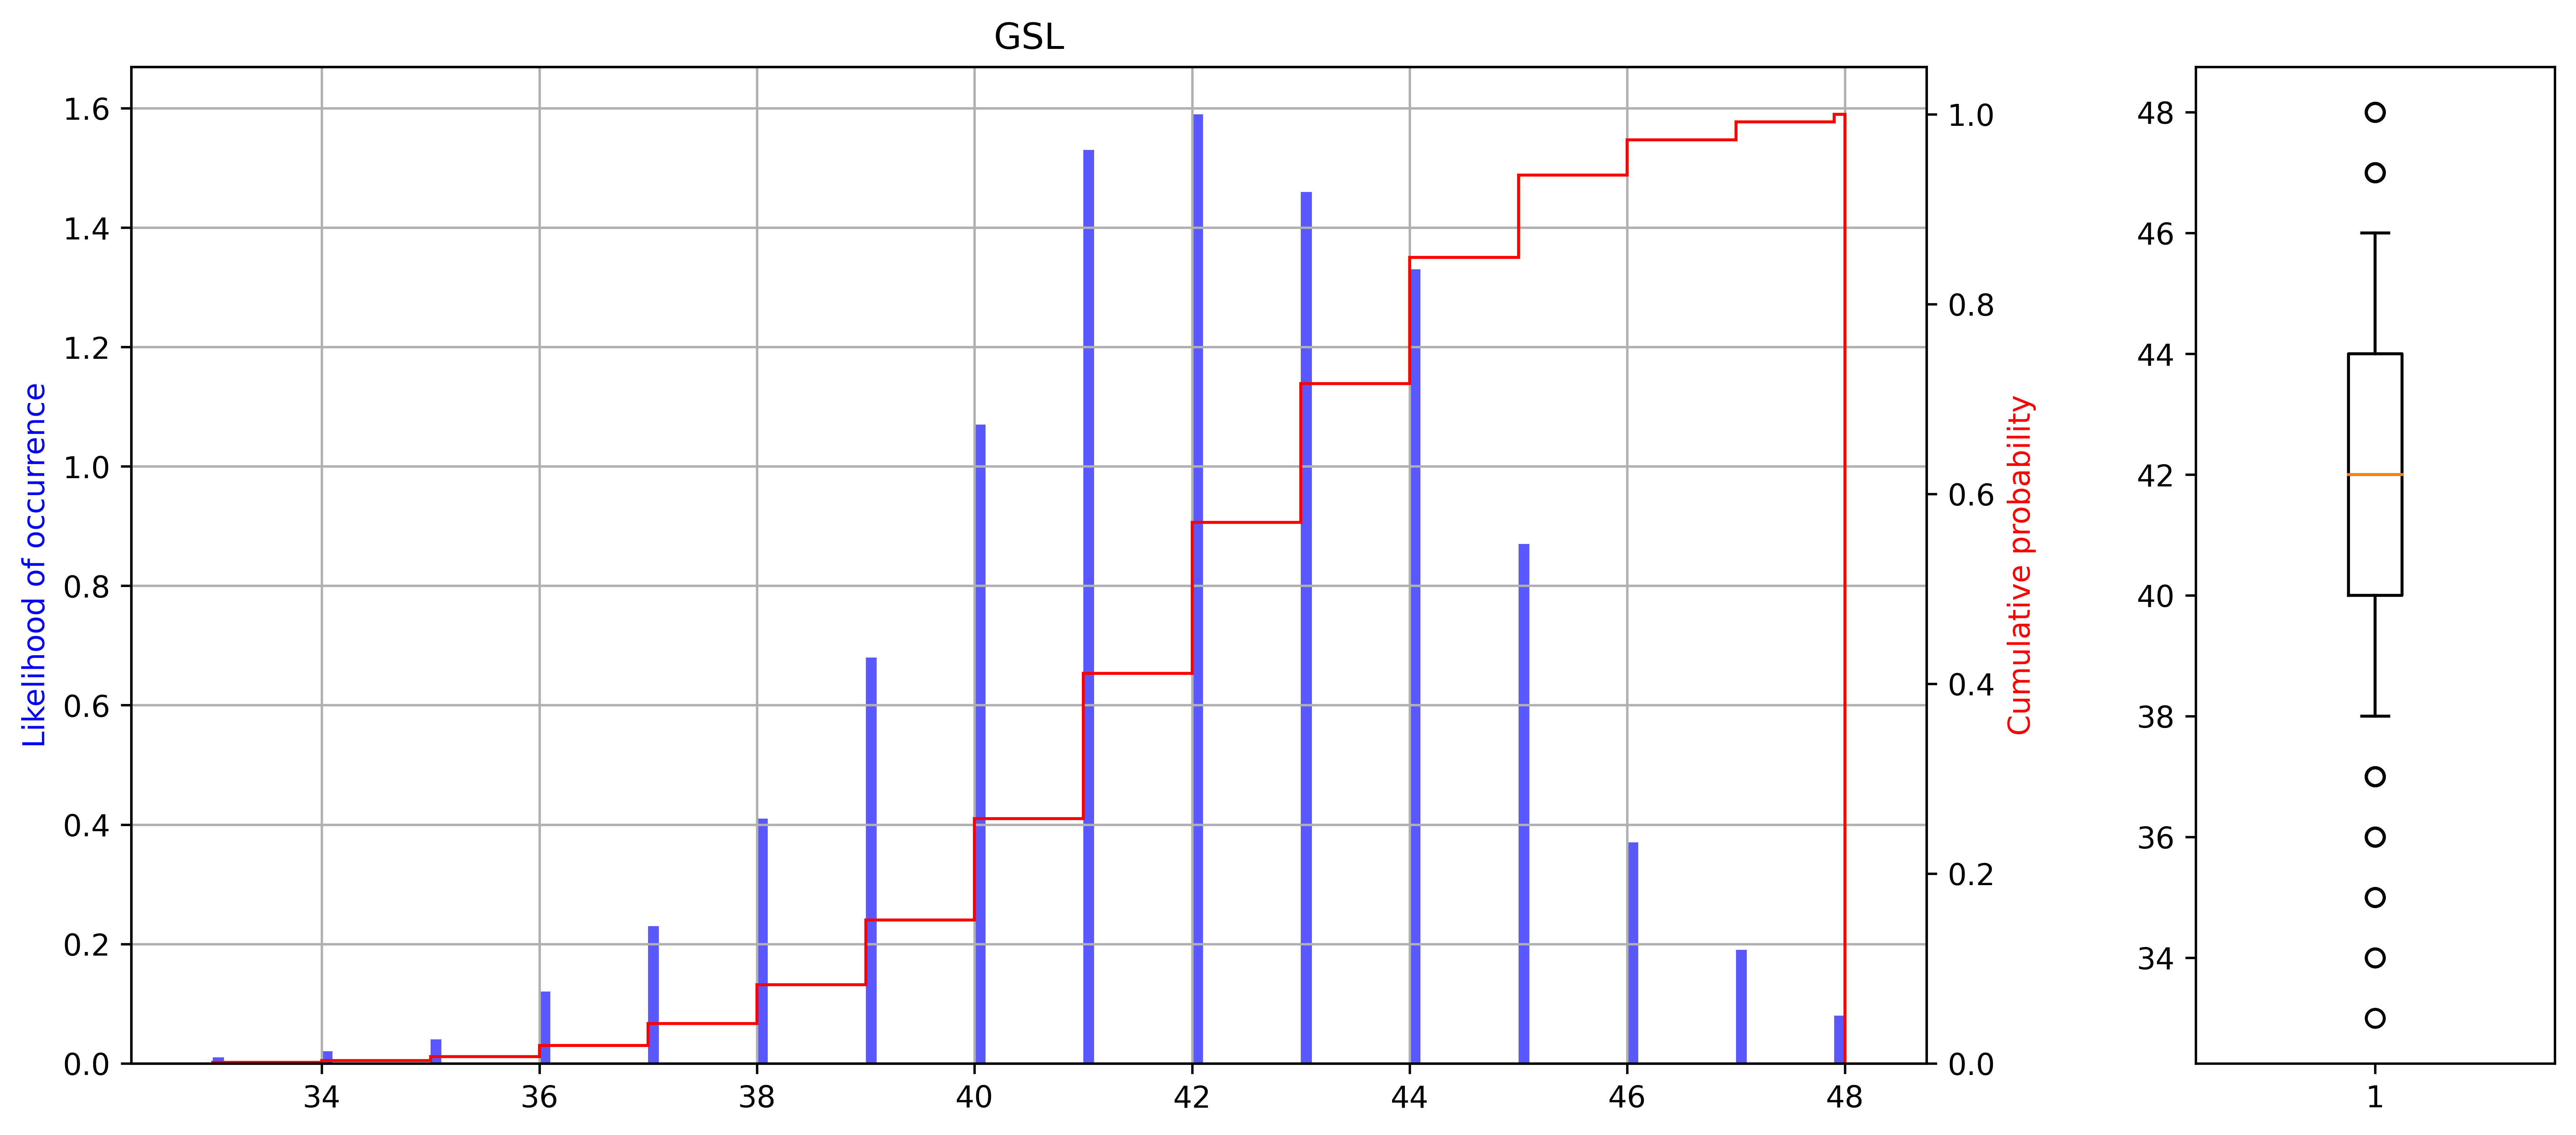

In [571]:
Result(x, z, Cost, t)

In [572]:
m1 = gp.Model("step1")

x1 = m1.addVars(n, 10, 5, vtype = GRB.BINARY, name='x')
y1 = m1.addVars(n, vtype=GRB.BINARY, name='y')

m1.addConstrs(gp.quicksum(x1[p,o,w] for o in O for w in W) + y1[p]== 1 for p in P)

m1.addConstrs(x1[p,o,w] <= (6 - abs(PatList.SurType[p] - OS.iloc[o][w]))/6  for w in W for o in O for p in P)

m1.addConstrs(gp.quicksum(x1[p,o,w]*PatList.ExpDur[p] for p in P) <= 8*60 for o in O for w in W)

m1.setObjective(gp.quicksum(PatList.ExpDur[p]*cp[PatList.SurType[p] - 1]*x1[p,o,w] for p in P for o in O for w in W)
               + gp.quicksum(cd[PatList.SurType[p] - 1]*y1[p] for p in P), GRB.MINIMIZE)

m1.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5150 rows, 5100 columns and 15100 nonzeros
Model fingerprint: 0x0ce4658c
Variable types: 0 continuous, 5100 integer (5100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e+03, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 5e+02]
Found heuristic solution: objective 723760.00000
Presolve removed 5118 rows and 4908 columns
Presolve time: 0.05s
Presolved: 32 rows, 192 columns, 384 nonzeros
Found heuristic solution: objective 524534.00000
Variable types: 0 continuous, 192 integer (192 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.06 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 524534 723760 

Optimal solution found (tolerance 1.00e-04)
Best objective 5

In [573]:
m2 = gp.Model("step2")

z1 = m2.addVars(n, 10, 5, samples, vtype = GRB.BINARY, name = "z")
t1 = m2.addVars(10, 5, samples, ub = 16*60, vtype=GRB.INTEGER, name='t')
    
Cost1 = m2.addVars(samples, obj = 1/samples, name = "COST")

#Set Constraints
m2.addConstrs((Cost1[i] == gp.quicksum(PatList.ExpDur[p]*cp[PatList.SurType[p] - 1]*(x1[p,o,w].x - z1[p,o,w,i]) for o in O for w in W for p in P)
        + gp.quicksum(co * t1[o,w,i] for o in O for w in W)
        + gp.quicksum(y1[p].x* cd[PatList.SurType[p] - 1] for p in P)
        + gp.quicksum(z1[p,o,w,i]*cc[PatList.SurType[p] - 1] for p in P for o in O for w in W) for i in range(samples)))

m2.addConstrs(x1[p,o,w].x >= z1[p,o,w,i] for i in range(samples) for p in P for o in O for w in W)

m2.addConstrs(gp.quicksum(x1[p,o,w].x*PatList.ExpDur[p] for p in P) + simulation[i].iloc[w,o] 
            - gp.quicksum(z1[p,o,w,i]*PatList.ExpDur[p] for p in P) 
            <= 8*60 + t1[o,w,i] for o in O for w in W for i in range(samples)) 

m2.update()
m2.setParam('MIPGap', 0.02)
m2.setParam('Timelimit', 3600)

m2.optimize()

Set parameter MIPGap to value 0.02
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5051000 rows, 5051000 columns and 15101000 nonzeros
Model fingerprint: 0x21384aba
Variable types: 1000 continuous, 5050000 integer (5000000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e-03, 1e-03]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 5e+05]
Presolve removed 5032046 rows and 4972394 columns (presolve time = 5s) ...
Presolve removed 5043121 rows and 5050995 columns (presolve time = 11s) ...
Presolve removed 5050999 rows and 5050995 columns
Presolve time: 11.12s
Presolved: 1 rows, 5 columns, 5 nonzeros
Variable types: 0 continuous, 5 integer (4 binary)
Found heuristic solution: objective 706666.79600

Explored 0 nodes (0 simplex iterations) in 18.26 seconds (8.55 work units)
Thread count was 8 (o

In [574]:
MSS2 = MSS(x1,y1)
print("first 10 scheduled patients:")
print()
print(MSS2.head(10))
print()
print("postponed patients:")
print()
print(MSS2[MSS2.ORNumber == "Postponed"])

first 10 scheduled patients:

          ORNumber    Weekday  SurType  ExpDur
PatNumber                                     
1                3     Monday        1     130
2                9     Monday        1     131
3                3     Monday        1     152
4                3     Firday        1     166
5                3     Firday        1     165
6                9     Firday        1     115
7                9     Monday        1     150
8                3  Wednesday        1     187
9                3  Wednesday        1     108
10               9     Monday        1     130

postponed patients:

            ORNumber Weekday  SurType  ExpDur
PatNumber                                    
17         Postponed     NaN        2     324
28         Postponed     NaN        2     281
30         Postponed     NaN        2     298
37         Postponed     NaN        3     169
40         Postponed     NaN        3     216
55         Postponed     NaN        3     197
57         Postp

The plan rate is 88.00
Avg cost 706666.796
Avg c-rate 7.88
Avg GSL 32.157
SD cost 38188.81623763056
SD c-rate 0.03
SD GSL 2.5307618923469977


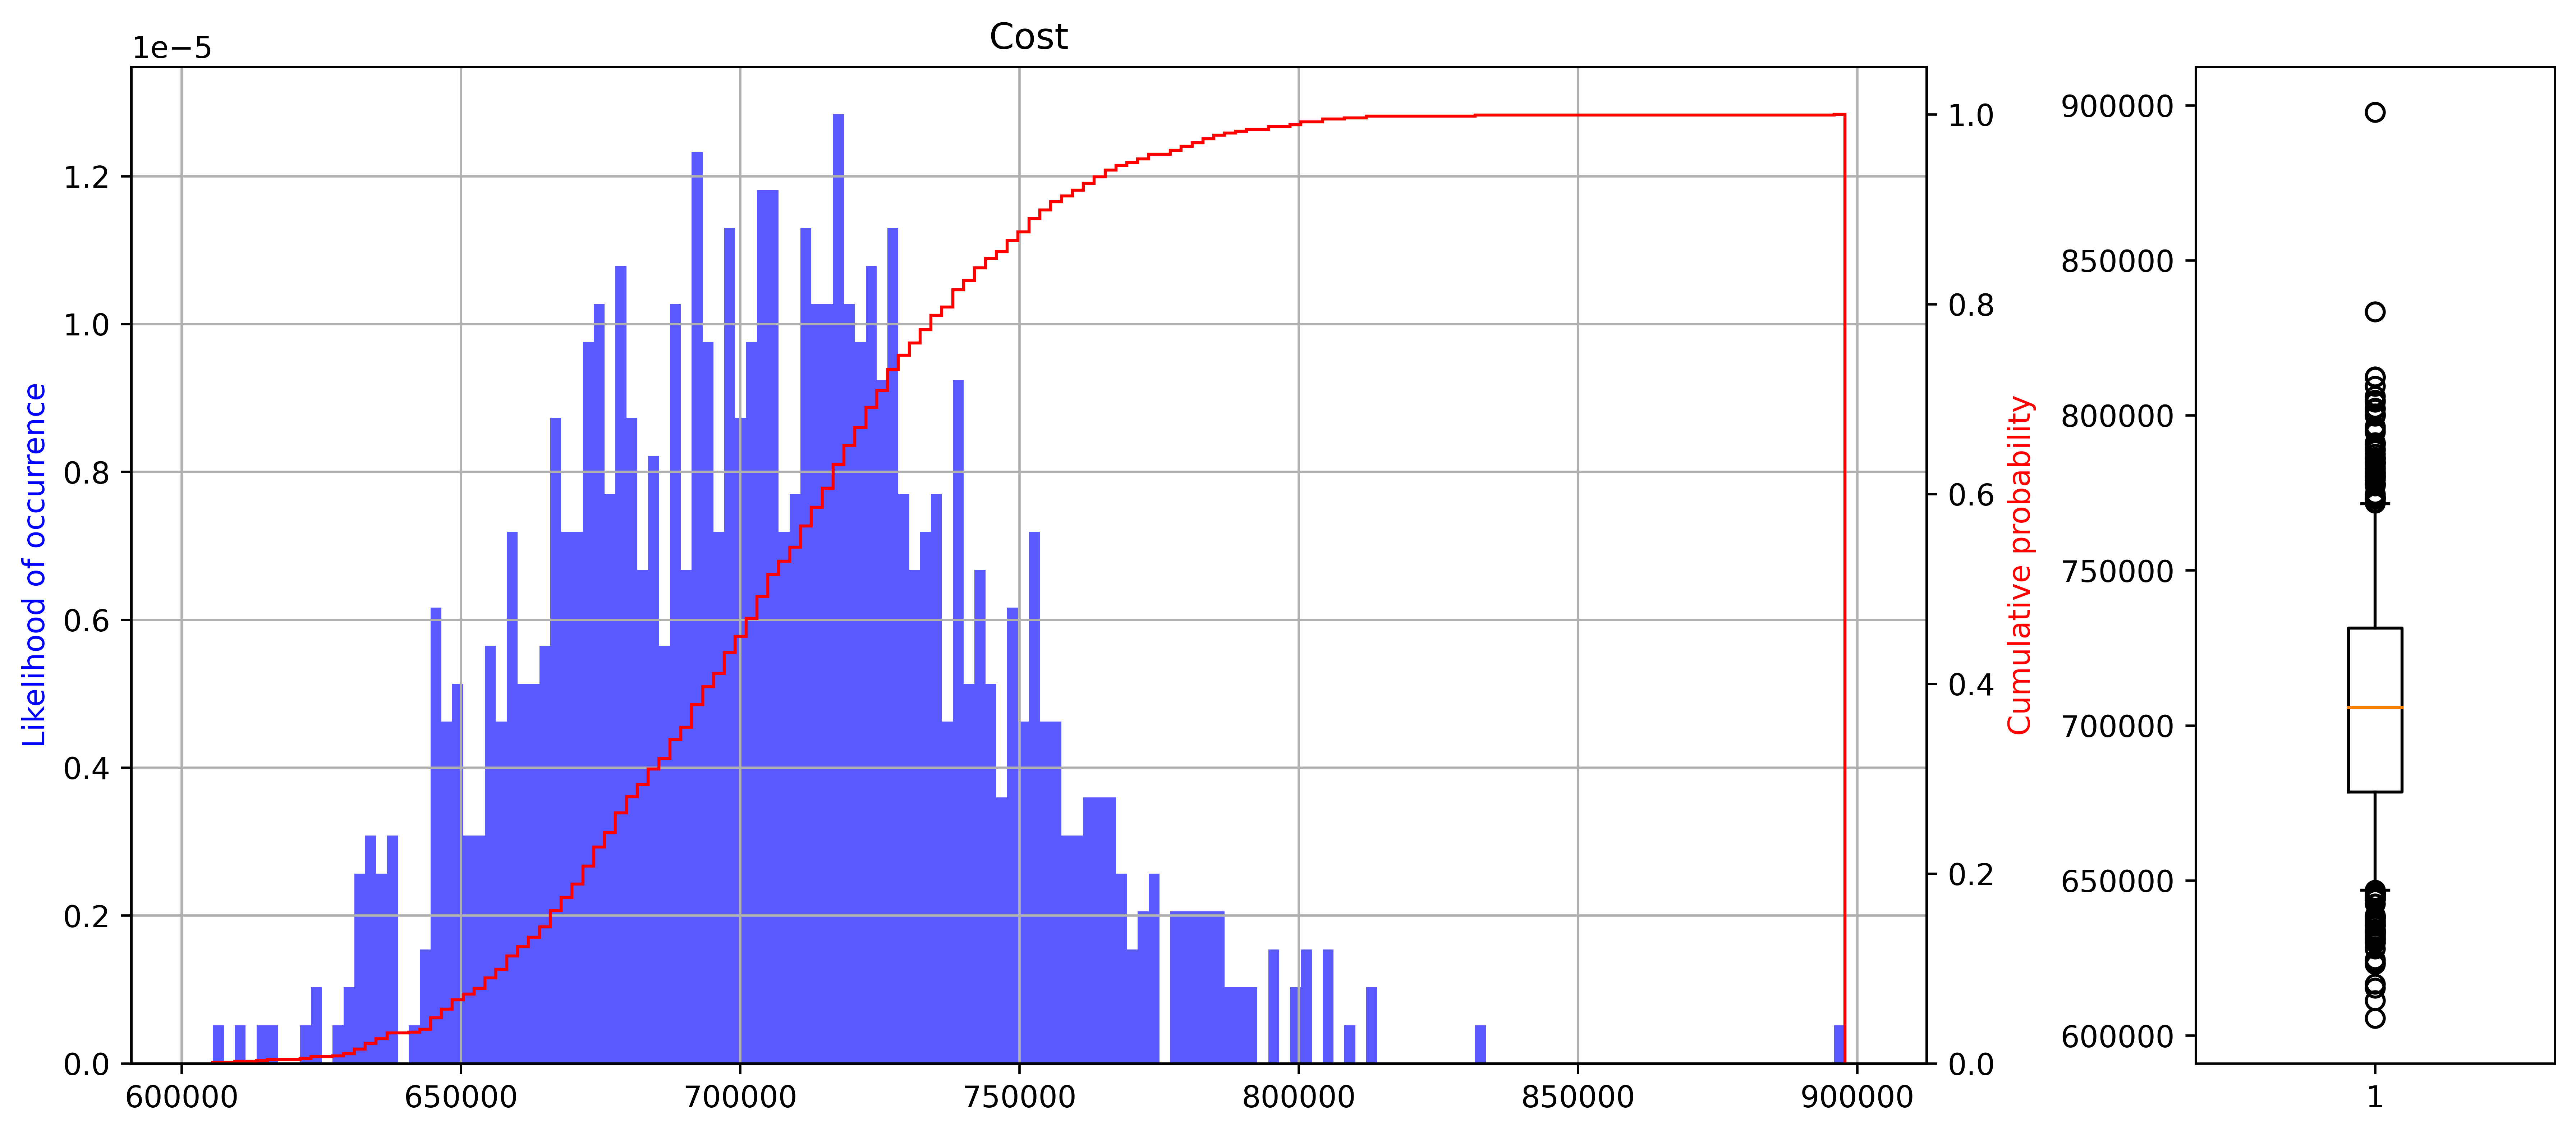

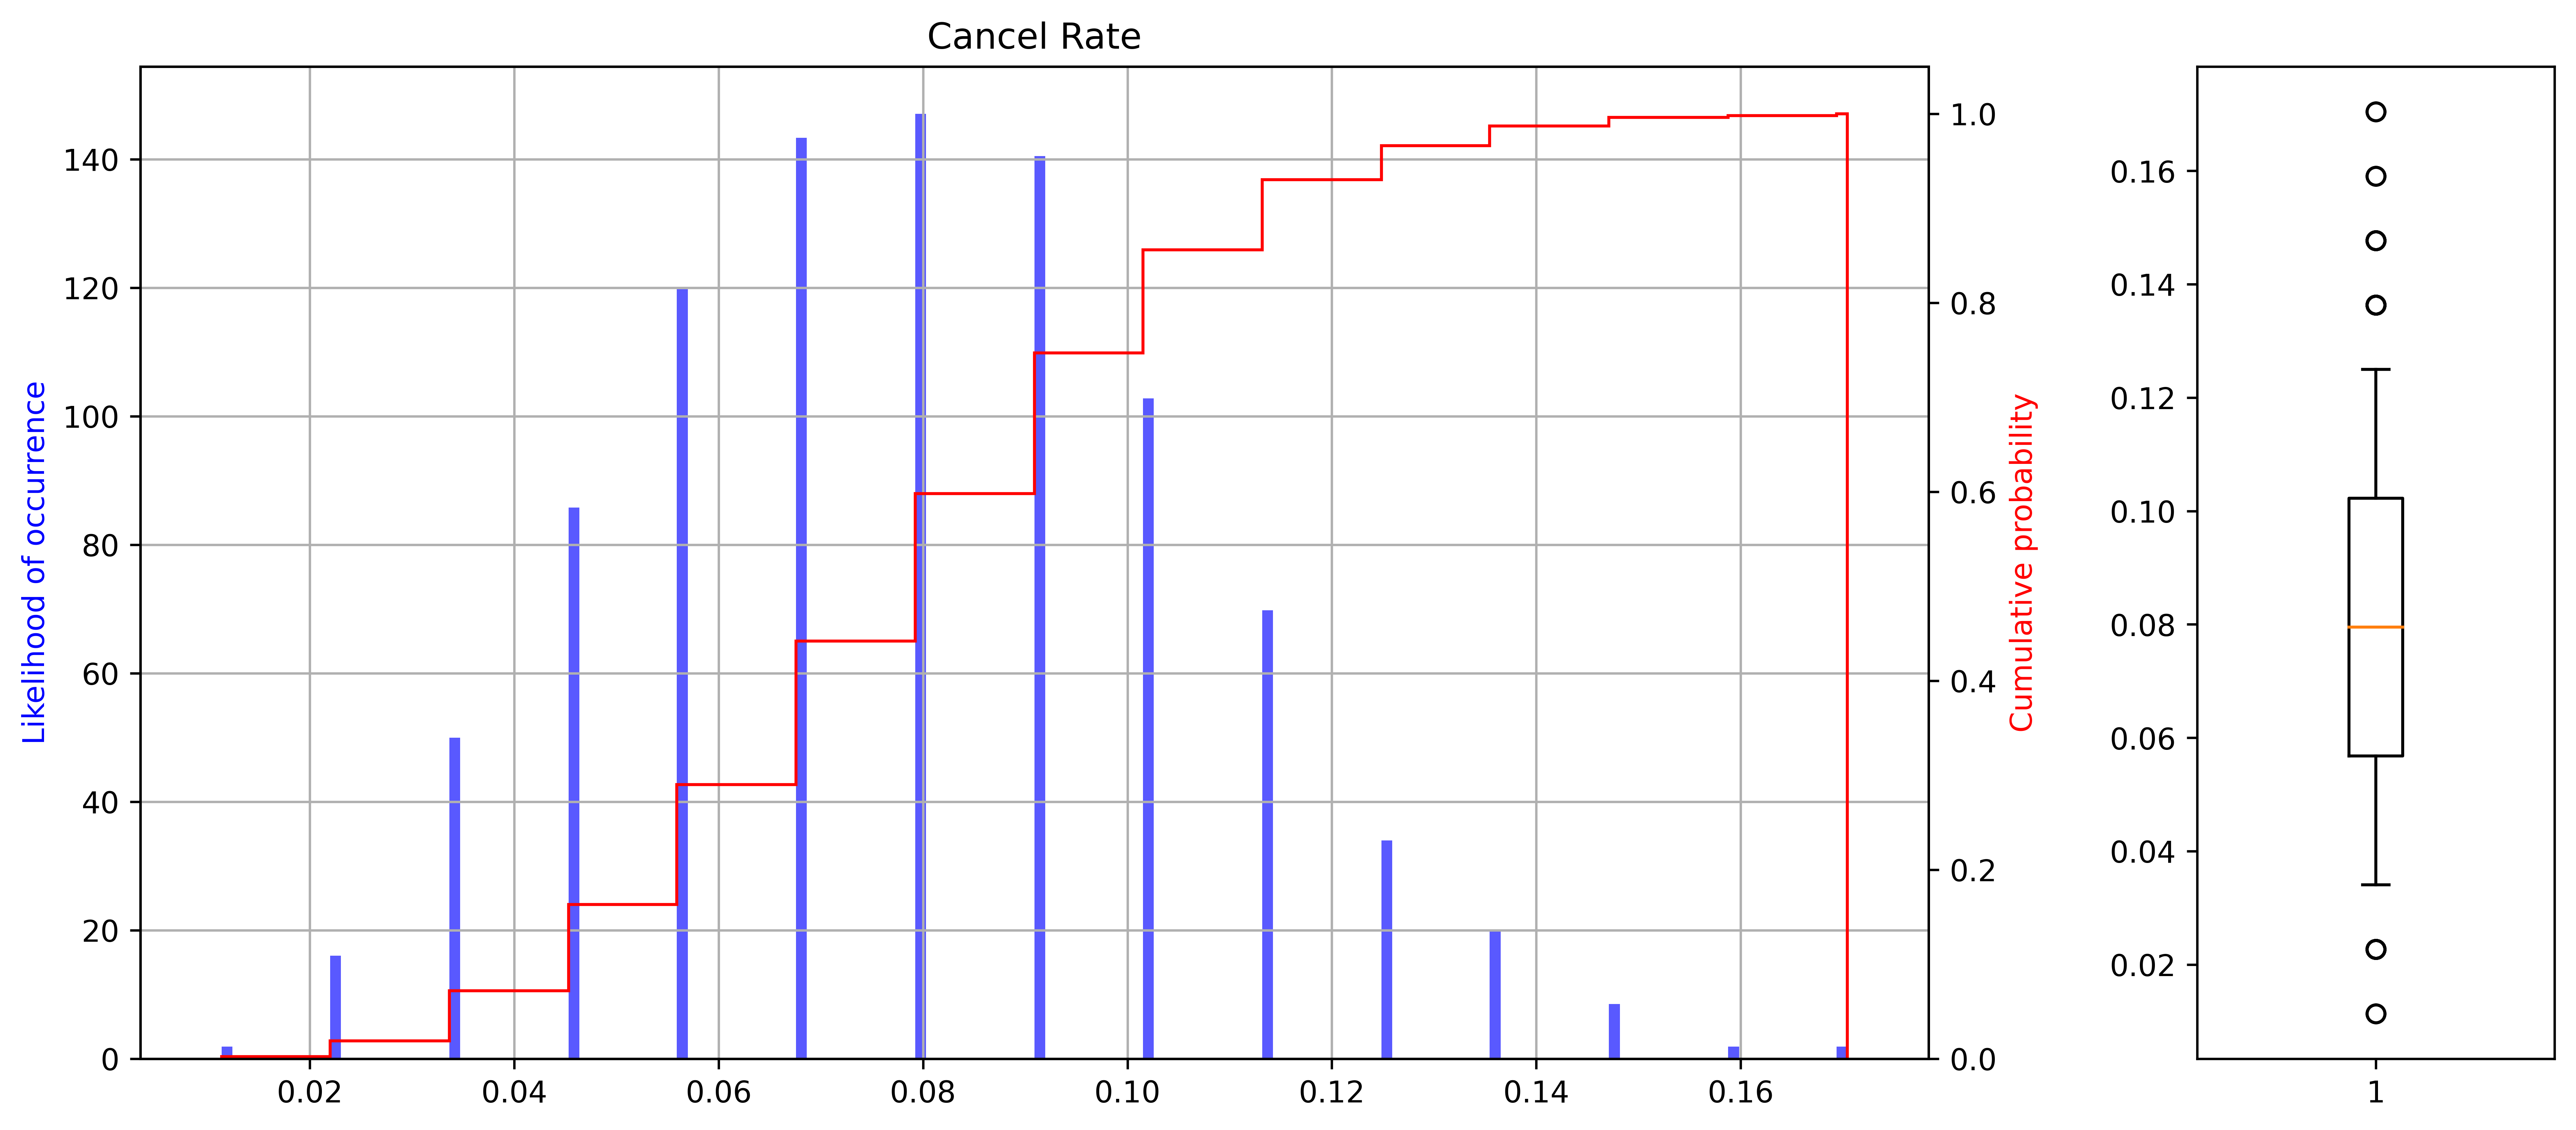

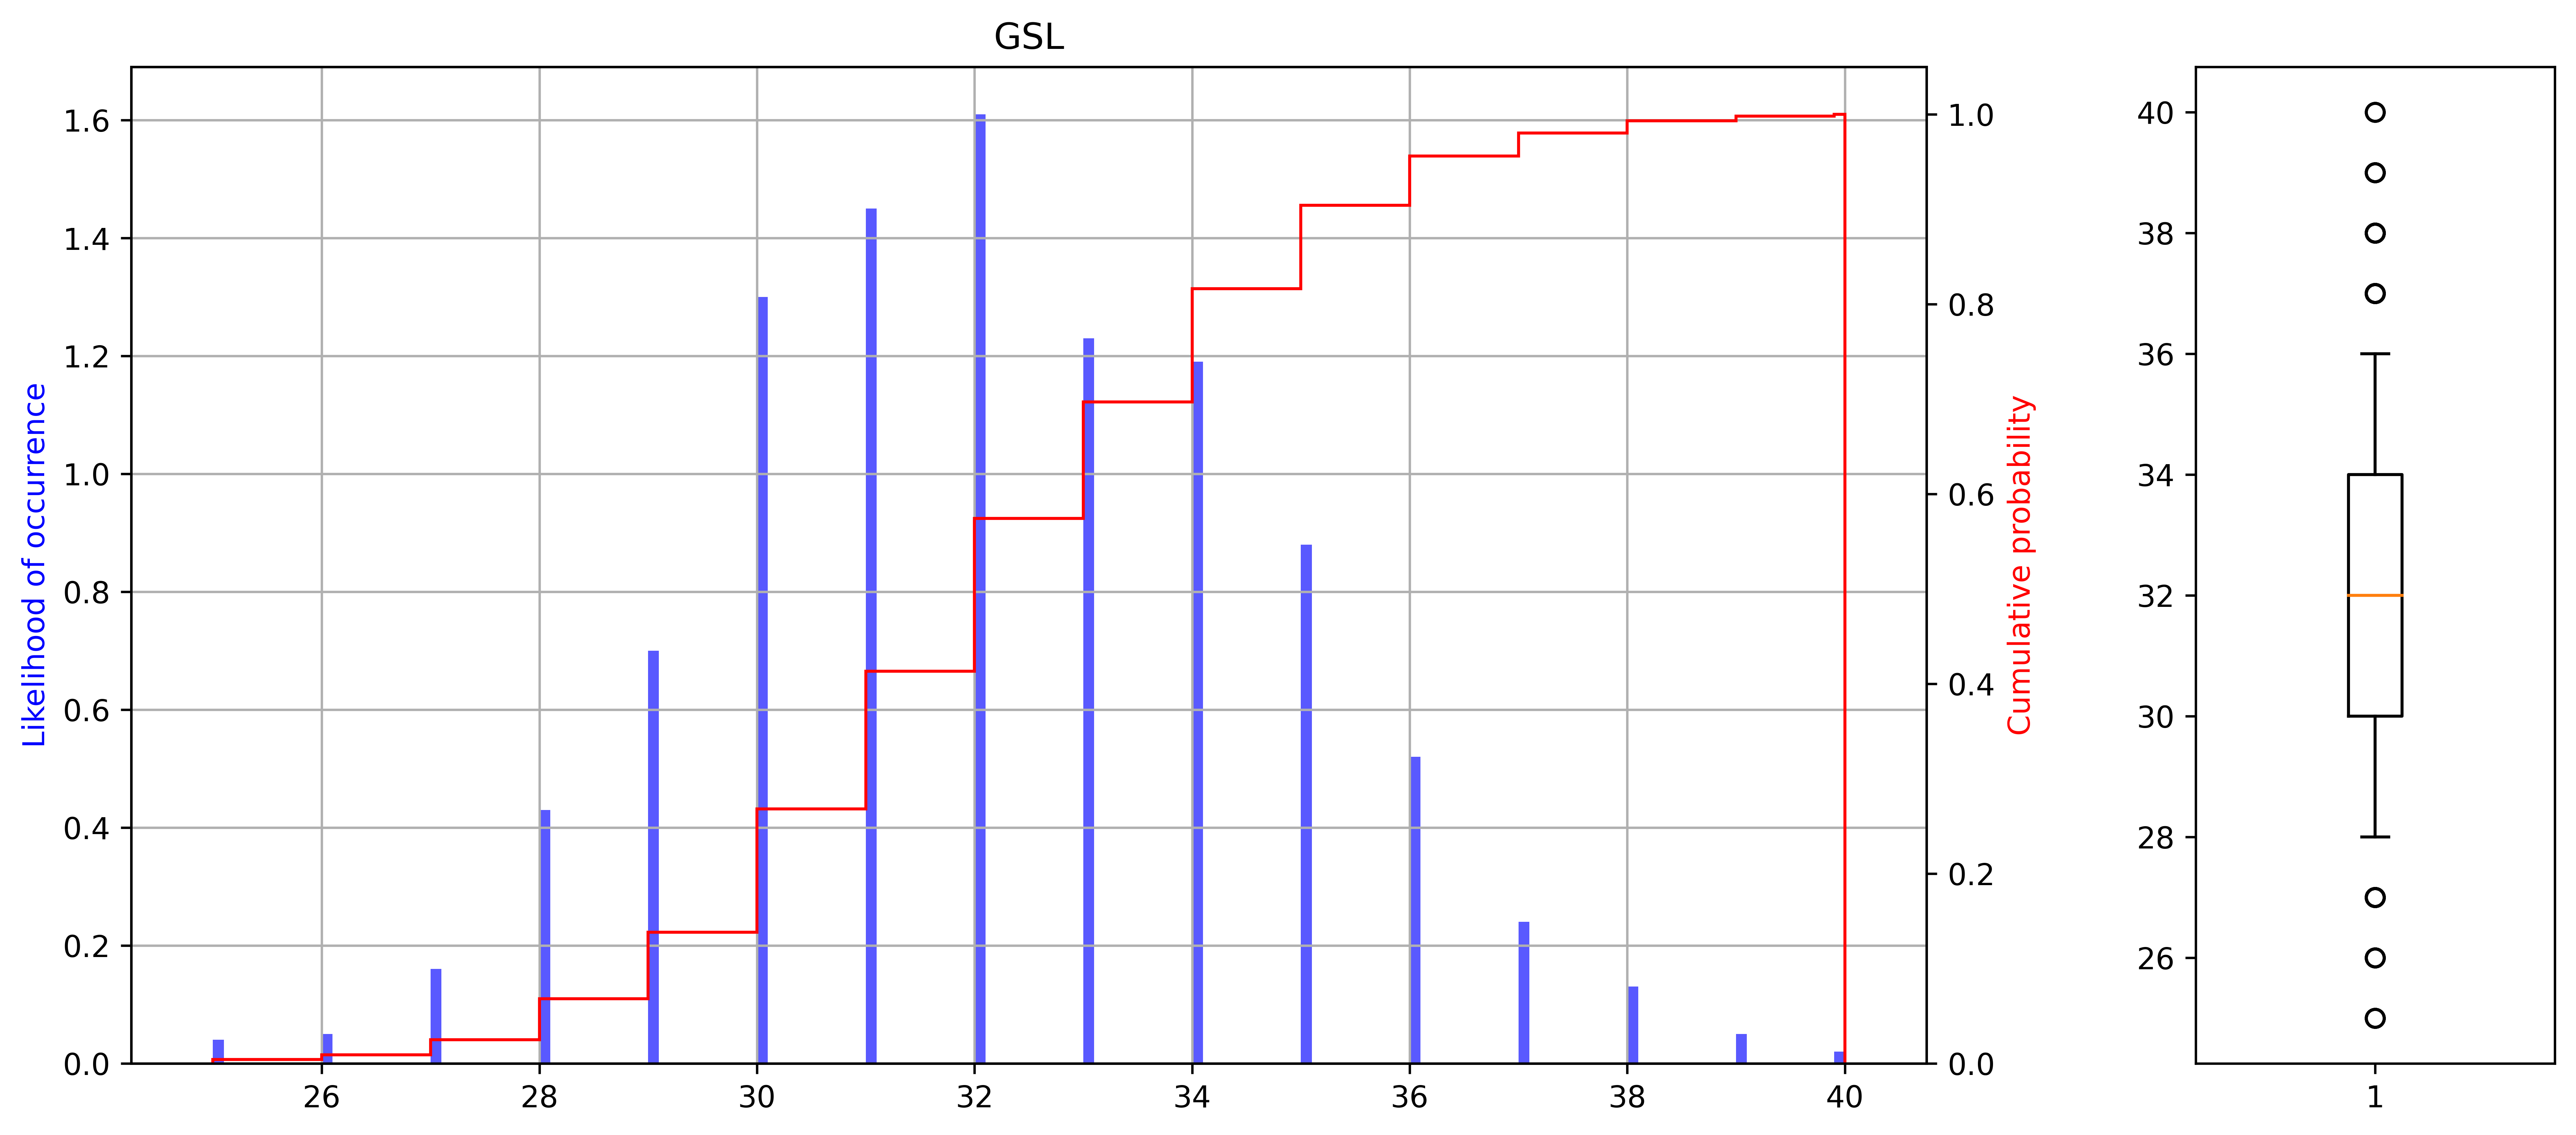

In [575]:
Result(x1, z1, Cost1, t1)